## DEMs coregistration demo
The srtm is selected as the master dem image.


In [1]:
import numpy as np
import xdem
import os
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff, writeTiff
from utils.get_img_extent import get_img_extent
from utils.crop2extent import tiles2extent


In [2]:
path_dem = 'data/aster-stereo/SETP-2003/aster-dem/VNIR_2003.89576568/run-DEM_wgs84_filter.tif'   # slave dem
path_dem_aligned = os.path.splitext(path_dem)[0]+'_coreg.tif'
### auxiliary
dir_srtm = 'data/dem-data/srtm-c/tiles'
dir_stable = 'data/land-cover/stable-cover/tiles-2010'

In [3]:
### data preparation
path_srtm_extent = 'srtm_extent.tif'
path_stable_extent = 'stable_extent.tif'
extent_dem, espg_dem = get_img_extent(path_dem)
print('extent:', extent_dem)
srtm_extent = tiles2extent(dir_tiled_data = dir_srtm, extent = extent_dem, path_save = path_srtm_extent)
stable_extent = tiles2extent(dir_tiled_data = dir_stable, extent = extent_dem, path_save = path_stable_extent)



extent: (98.39976272429986, 99.1627375609025, 27.854844859834994, 28.497319494453315)
0...10...20...30...40...50...60...70...80...90...100 - done.

0...10...20...30...40...50...60...70...80...90...100 - done.



### 1. Check dem images, and water/glacier mask images.

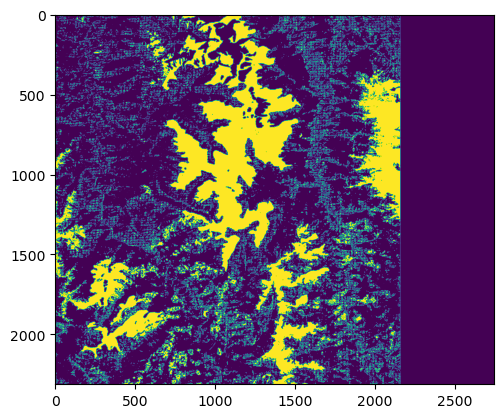

In [4]:
plt.imshow(stable_extent)


srtm: (2313, 2747) dem: (2313, 2747)
(1, 2313, 2747)


/home/xin/miniconda3/envs/venv-glacier/lib/python3.9/site-packages/geoutils/georaster/raster.py:1185: UserWarning: Only nodata is different, consider using the 'set_ndv()' method instead'                    ' -> return self (not a copy!)
  warnings.warn(
/home/xin/miniconda3/envs/venv-glacier/lib/python3.9/site-packages/geoutils/georaster/raster.py:1185: UserWarning: Only nodata is different, consider using the 'set_ndv()' method instead'                    ' -> return self (not a copy!)
  warnings.warn(


Text(0.5, 1.0, 'stable_mask')

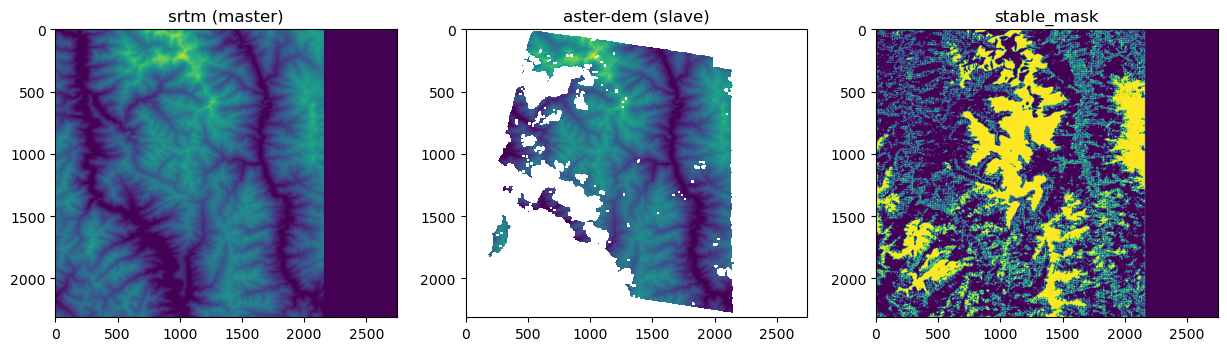

In [5]:
srtm, srtm_info = readTiff(path_srtm_extent)    # master dem

### --1. data reading
srtm = xdem.DEM(path_srtm_extent)            # master dem 
dem = xdem.DEM(path_dem).reproject(srtm)      # slave dem
srtm = srtm.reproject(dem)       #### Ensure the geo-info are completely the same. !!!some bug for the xdem

print('srtm:', srtm.shape, 'dem:', dem.shape)

### --2. stable mask 
stable_mask = xdem.DEM(path_stable_extent).reproject(srtm)
stable_mask = stable_mask.data[0].astype(bool)

### --3. image visualize
print(srtm.data.shape)
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1); plt.imshow(srtm.data[0], vmin=2000, vmax=7000); plt.title('srtm (master)')
plt.subplot(1,3,2); plt.imshow(dem.data[0], vmin=2000, vmax=7000); plt.title('aster-dem (slave)')
plt.subplot(1,3,3); plt.imshow(stable_mask); plt.title('stable_mask')



### **2. Co-registration to srtm-c dem by using open-source pybob code.**
##### (Reference: Nuth and Kääb (2011) (https://www.the-cryosphere.net/5/271/2011/tc-5-271-2011.html))


In [6]:
nuth_kaab = xdem.coreg.NuthKaab(max_iterations=20, offset_threshold=0.05)  # offset_threshold is the distance threshold
try:
    nuth_kaab.fit(reference_dem=srtm, dem_to_be_aligned=dem, inlier_mask=stable_mask, verbose=True)
    dem_aligned = nuth_kaab.apply(dem)
except:
    print('!!!The aster dem coregistration is failed')
    pass


Running Nuth and Kääb (2011) coregistration
   Calculate slope and aspect
   Statistics on initial dh:
      Median = 12.44 - NMAD = 17.26
   Iteratively estimating horizontal shit:


   Progress:   0%|          | 0/20 [00:00<?, ?it/s]

      #1 - Offset in pixels : (0.53, -0.50)


   Progress:   5%|▌         | 1/20 [00:00<00:07,  2.45it/s]

      Median = 13.12 - NMAD = 12.95  ==>  Gain = -24.99%
      #2 - Offset in pixels : (0.00, -0.03)


   Progress:  10%|█         | 2/20 [00:01<00:07,  2.39it/s]

      Median = 13.10 - NMAD = 12.95  ==>  Gain = -0.03%
      #3 - Offset in pixels : (-0.00, -0.00)


   Progress:  10%|█         | 2/20 [00:01<00:11,  1.56it/s]


      Median = 13.10 - NMAD = 12.95  ==>  Gain = 0.00%
   Last offset was below the residual offset threshold of 0.05 -> stopping

   Final offset in pixels (east, north) : (0.535842, -0.533106)
   Statistics on coregistered dh:
      Median = 13.10 - NMAD = 12.95


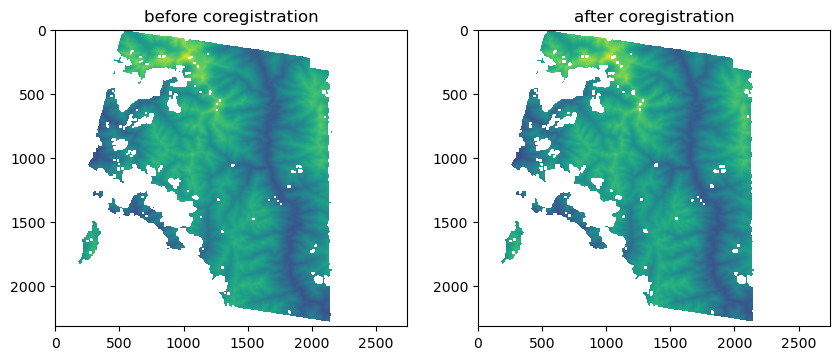

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(dem.data[0], vmax=7000, vmin=0); plt.title('before coregistration')
plt.subplot(1,2,2)
plt.imshow(dem_aligned.data[0], vmax=7000, vmin=0); plt.title('after coregistration')
# writeTiff(dem_aligned.data[0], srtm_info['geotrans'], srtm_info['geosrs'], path_dem_aligned) 
dem_aligned.save(path_dem_aligned)


### **3. Compare the dem difference before and after dems co-registration**

In [8]:
diff_before = srtm - dem             ## before coregistation
diff_after = srtm - dem_aligned      ## after coregistation
inliers_before = diff_before.data[0][stable_mask].compressed()
med_before, nmad_before = np.nanmedian(inliers_before), xdem.spatialstats.nmad(inliers_before)
inliers_after = diff_after.data[0][stable_mask].compressed()
med_after, nmad_after = np.nanmedian(inliers_after), xdem.spatialstats.nmad(inliers_after)
print(f"Error before: median = {med_before:.2f}; NMAD = {nmad_before:.2f} m")
print(f"Error after: median = {med_after:.2f}; NMAD = {nmad_after:.2f} m")


Error before: median = 12.44; NMAD = 17.26 m
Error after: median = 0.02; NMAD = 12.98 m


Text(0.5, 1.0, 'after co-registration')

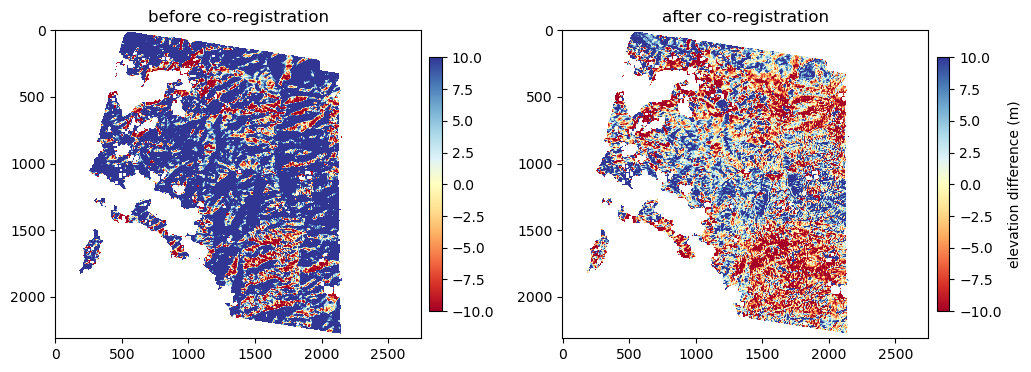

In [9]:
fig1 = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(diff_before.data[0], vmin=-10, vmax=10, cmap='RdYlBu')
cb = plt.colorbar(fraction=0.03, pad=0.02); 
plt.title('before co-registration')

plt.subplot(1,2,2)
plt.imshow(diff_after.data[0], vmin=-10, vmax=10, cmap='RdYlBu')
cb = plt.colorbar(fraction=0.03, pad=0.02); 
cb.set_label('elevation difference (m)')
plt.title('after co-registration')
